In [85]:
import pandas as pd
import numpy as np
import torch
import sklearn
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os
import time

In [86]:
'''for f in os.listdir('stocks'):
    if os.path.getsize('stocks/'+f)<7000:
        os.remove('stocks/'+f)
for f in os.listdir('etfs'):
    if os.path.getsize('etfs/'+f)<7000:
        os.remove('etfs/'+f)'''

"for f in os.listdir('stocks'):\n    if os.path.getsize('stocks/'+f)<7000:\n        os.remove('stocks/'+f)\nfor f in os.listdir('etfs'):\n    if os.path.getsize('etfs/'+f)<7000:\n        os.remove('etfs/'+f)"

In [87]:
l1=os.listdir('stocks')
l2=os.listdir('etfs')
device=torch.device('cuda:0')

In [88]:
def generate(a):
    df=pd.read_csv(a).filter(['Open','High','Low','Close','Adj Close','Volume'])
    df=df.dropna()
    df=np.array(df)
    df=df[:-1]-df[1:]
    transprices=RobustScaler().fit(df[:,:-1])
    df[:,:-1]=transprices.transform(df[:,:-1])
    a=np.max(np.abs(df[:,:-1]))
    b=np.max(np.abs(df[:,-1]))
    df[:,:-1]=df[:,:-1]/a
    df[:,-1]=df[:,-1]/b
    return df,a,b,transprices

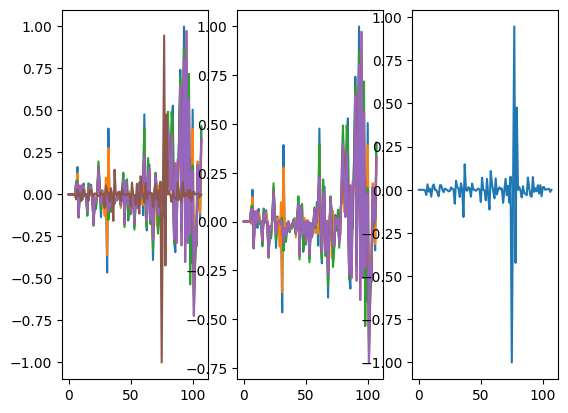

In [89]:
random.shuffle(l1)
random.shuffle(l2)
xx='etfs/'+l2[0]
df,_,__,transa=generate(xx)
fig,ax=plt.subplots(1,3)
ax[0].plot(df)
ax[1].plot(df[:,:-1])
ax[2].plot(df[:,-1])
plt.show()

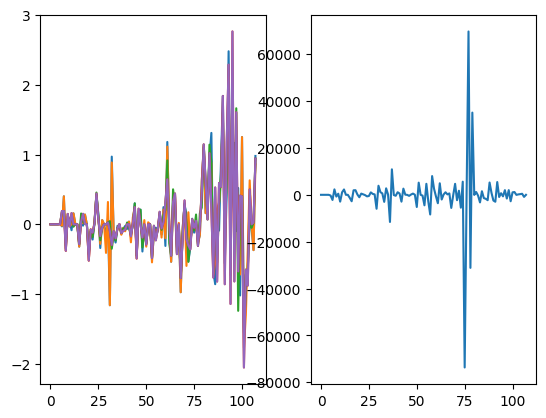

In [90]:
#restoring
def restorePreds(d,_,__,transa):
    df=d.copy()
    df[:,:-1]=transa.inverse_transform(df[:,:-1]*_)
    df[:,-1]=df[:,-1]*__
    return df
df=restorePreds(df,_,__,transa)
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:-1])
ax[1].plot(df[:,-1])
plt.show()

In [91]:
def create(dataset,lb,lf=1):
    X,y=[],[]
    for i in range(len(dataset)-lb-lf+1):
        X.append(np.array(dataset[i:i+lb]))
        y.append(np.array(dataset[i+1:i+lb+lf]))
    return torch.tensor(np.array(X)).float(),torch.tensor(np.array(y)).float()

In [92]:
lb=50
X_train,y_train=create(df,lb=lb)

PHASE 1a1: LSTM PREDICTION

In [93]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(input_size=6,hidden_size=100,num_layers=2,dropout=0.1,batch_first=True)
        self.l1=nn.Linear(100,20)
        self.l2=nn.Linear(20,6)
    def forward(self,x):
        x,_=self.lstm(x)
        x=self.l1(x)
        x=self.l2(x)
        return x

In [94]:
model=LSTMModel()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3,step_size_up=10000,mode="triangular2",cycle_momentum=False)

In [95]:
def signloss(y_pred,y):
    return torch.ceil(-y_pred*y)

In [96]:
def lstmloss(y_pred,y):
    return torch.clip(2*torch.mean((torch.square(y_pred-y)*10+signloss(y_pred,y))*torch.cat((torch.abs(y[:,:,:-1]),torch.ones((y.shape[0],50,1)).to('cuda')/50),axis=2)),max=0.1)

In [97]:
def train(n_epochs,dl,lf=1):
    for i in range(n_epochs):
        for X,y in dl:
            y=y.to(device)
            logits=0
            y_pred=model(X.to(device))
            logits+=lstmloss(y_pred,y[:,:lb])
            for j in range(1,lf):
                y_pred=model(y_pred)
                logits+=lstmloss(y_pred,y[:,j:j+lb])
            logits=logits/lf
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(),'lstmmodel.pt')

In [98]:
'''model.train()
for i in l2[:100]:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(1,dl)'''

"model.train()\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(1,dl)"

PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [99]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb,lf=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb,lf=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [100]:
'''random.shuffle(l1);random.shuffle(l2)
for i in l2:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb,lf=50)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,50)'''

"random.shuffle(l1);random.shuffle(l2)\nfor i in l2:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb,lf=50)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,50)"

In [101]:
model.load_state_dict(torch.load('lstmmodel.pt'))

C:\Users\edwin\AppData\Local\Temp\ipykernel_4840\2978307079.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstmmodel.pt'))


<All keys matched successfully>

In [102]:
xx='etfs/'+random.choice(l2)
print(xx)

etfs/MJ.csv


In [103]:
model.eval() #NOT EVAL IN FINAL PREDICTIONS
tester='etfs/'+'IGN.csv'
df,a,b,transprices=generate(xx)
X_test,y_test=create(df,lb=lb)
dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test,y_test),shuffle=False,batch_size=1)
qwer=True
for X,y in dl:
    if qwer:
        ggg=list(X.detach().numpy()[0])
        qwer=False
    ggg.append(model(X.to(device))[0][-1].detach().cpu().numpy())

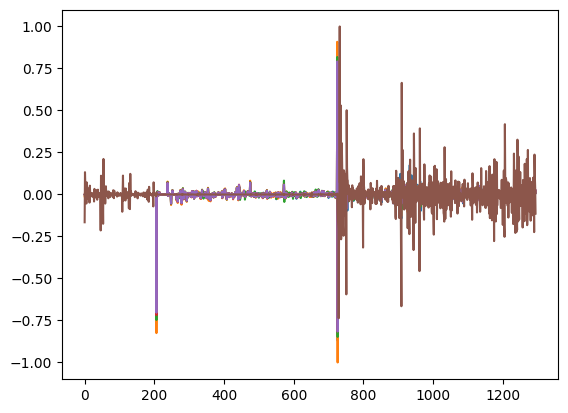

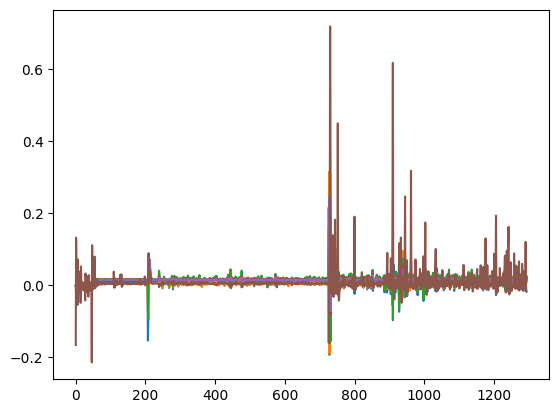

In [104]:
fig,ax=plt.subplots()
ax.plot(df)
fig,ax=plt.subplots()
ax.plot(ggg)

(1296, 6)


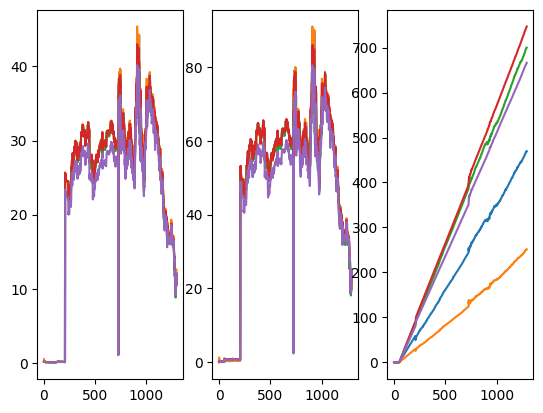

In [105]:
d2=np.array(pd.read_csv(xx).filter(['Open','High','Low','Close','Adj Close','Volume']))
print(d2.shape)
fig,ax=plt.subplots(1,3)
ax[0].plot(d2[1:,:-1])
ggg=np.array(ggg)
ggg1=restorePreds(ggg,a,b,transprices)
test2=d2[0:-1,:-1]+d2[:-1,:-1]+ggg1[:,:-1]
ax[1].plot(test2[:-1])
testult=[d2[0]]
for i in range(ggg1.shape[0]):
    testult.append(np.sum(ggg1[:i+1],axis=0))
ax[2].plot(np.array(testult)[:-1,:-1])

In [106]:
pp=np.sum(np.ceil(ggg))
pn=np.sum(np.ceil(-ggg))
p=np.sum(np.ceil(df))
n=np.sum(np.ceil(-df))
tp=np.sum(np.ceil(ggg)*np.ceil(df))
tn=np.sum(np.ceil(-ggg)*np.ceil(-df))
recall=tp/p
precision=tp/pp
print('recall: ',recall)
print('precision: ',precision)
print('acc: ',(tp+tn)/(p+n))
print('f1: ',2*recall*precision/(recall+precision))

recall:  0.9552327305069671
precision:  0.45923603192702395
acc:  0.5718677940046119
f1:  0.6202714409471556


PHASE 1b1: LGBM

In [107]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [109]:
p_data = pd.read_csv(xx).filter(['Open','High','Low','Close','Adj Close','Volume'])

In [110]:
p_data

,Open,High,Low,Close,Adj Close,Volume
0,0.130,0.150,0.100,0.140,0.127545,82500
1,0.165,0.490,0.125,0.150,0.136656,766635
2,0.120,0.160,0.110,0.125,0.113880,218023
3,0.130,0.130,0.130,0.130,0.118435,70500
4,0.130,0.130,0.120,0.125,0.113880,200000
...,...,...,...,...,...,...
1291,11.280,12.650,11.264,12.110,12.110000,1983400
1292,11.880,12.430,11.791,12.130,12.130000,1002300
1293,12.000,12.080,11.400,11.550,11.550000,570800
1294,11.360,11.910,11.250,11.400,11.400000,408600


In [111]:
total_start_time = time.time()

for col in p_data.columns:
    # Record start time for the column
    start_time = time.time()
    
    # Load data
    data = d2
    X = pd.DataFrame(p_data)
    y = pd.Series(p_data[col])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }

    # Train the model
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Record end time for the column
    end_time = time.time()
    column_runtime = end_time - start_time
    
    print(f'===== Column "{col}" =====')
    print(f'Runtime: {column_runtime:.5f}s')
    print(f'RMSE: {rmse}')

# Calculate total runtime
total_end_time = time.time()
total_runtime = total_end_time - total_start_time
print(f'\nTotal runtime: {total_runtime:.5f}s')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.175764
===== Column "Open" =====
Runtime: 0.05173s
RMSE: 0.17576371503271454
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.156611
===== Column "High" =====
Runtime: 0.04627s
RMSE: 0.15661054119287288
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.153553
===== Column "Low" =====
Runtime: 0.05688s
RMSE: 0.1535525251132961
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.156026
===== Column "Close" =====
Runtime: 0.05857s
RMSE: 0.15602568017276053
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.15334
===== Column "Adj Clos